_Lambda School Data Science, Unit 2_
 
# Classification 1 Sprint Challenge: Predict Steph Curry's shots 🏀

For your Sprint Challenge, you'll use a dataset with all Steph Curry's NBA field goal attempts. (Regular season and playoff games, from October 28, 2009, through June 5, 2019.) 

You'll use information about the shot and the game to predict whether the shot was made. This is hard to predict! Try for an accuracy score in the high 50's or low 60's. The dataset was collected with the [nba_api](https://github.com/swar/nba_api) Python library.

In [1]:
import pandas as pd
url = 'https://drive.google.com/uc?export=download&id=1fL7KPyxgGYfQDsuJoBWHIWwCAf-HTFpX'
df = pd.read_csv(url, parse_dates=['game_date']).set_index('game_date')
assert df.shape == (13958, 19)

This Sprint Challenge has two parts. To demonstrate mastery on each part, do all the required, numbered instructions. To earn a score of "3" for the part, also do the stretch goals.

## Part 1. Prepare to model

### Required

1. **Do train/validate/test split.** Use the 2009-10 season through 2016-17 season to train, the 2017-18 season to validate, and the 2018-19 season to test. NBA seasons begin in October and end in June. You'll know you've split the data correctly when your train set has 11081 observations, your validation set has 1168 observations, and your test set has 1709 observations.
2. **Begin with baselines for classification.** Your target to predict is `shot_made_flag`. What is the baseline accuracy for the validation set, if you guessed the majority class for every prediction?
3. **Use Ordinal Encoding _or_ One-Hot Encoding,** for the categorical features you select.
4. **Train a Random Forest _or_ Logistic Regression** with the features you select.

### Stretch goals
Engineer at least 4 of these 5 features:

- **Homecourt Advantage**: Is the home team (`htm`) the Golden State Warriors (`GSW`) ?
- **Opponent**: Who is the other team playing the Golden State Warriors?
- **Seconds remaining in the period**: Combine minutes remaining with seconds remaining, to get the total number of seconds remaining in the period.
- **Seconds remaining in the game**: Combine period, and seconds remaining in the period, to get the total number of seconds remaining in the game. A basketball game has 4 periods, each 12 minutes long.
- **Made previous shot**: Was Steph Curry's previous shot successful?
    

## Part 2. Evaluate models

### Required
1. Get your model's **validation accuracy.** (Multiple times if you try multiple iterations.)
2. Get your model's **test accuracy.** (One time, at the end.)
3. Get and plot your Random Forest's **feature importances** _or_ your Logistic Regression's **coefficients.**
4. Imagine this is the confusion matrix for a binary classification model. **Calculate accuracy, precision, and recall for this confusion matrix:**

<table>
  <tr>
    <td colspan="2" rowspan="2"></td>
    <td colspan="2">Predicted</td>
  </tr>
  <tr>
    <td>Negative</td>
    <td>Positive</td>
  </tr>
  <tr>
    <td rowspan="2">Actual</td>
    <td>Negative</td>
    <td style="border: solid">85</td>
    <td style="border: solid">58</td>
  </tr>
  <tr>
    <td>Positive</td>
    <td style="border: solid">8</td>
    <td style="border: solid"> 36</td>
  </tr>
</table>


### Stretch goals
- Calculate F1 score for the provided, imaginary confusion matrix.
- Plot a real confusion matrix for your basketball model, with row and column labels.
- Print the classification report for your model.

# Part 1. Prepare to model

In [2]:
df.head(1)

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,htm,vtm,season_type,scoremargin_before_shot
game_date,,,,,,,,,,,,,,,,,,,
2009-10-28,20900015,4,Stephen Curry,1,11,25,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,99,249,0,GSW,HOU,Regular Season,2.0


In [58]:
df.isna().sum()

game_id                    0
game_event_id              0
player_name                0
period                     0
minutes_remaining          0
seconds_remaining          0
action_type                0
shot_type                  0
shot_zone_basic            0
shot_zone_area             0
shot_zone_range            0
shot_distance              0
loc_x                      0
loc_y                      0
shot_made_flag             0
htm                        0
vtm                        0
season_type                0
scoremargin_before_shot    0
dtype: int64

In [57]:
df.describe(exclude='number')

,player_name,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,htm,vtm,season_type
count,13958,13958,13958,13958,13958,13958,13958,13958,13958
unique,1,53,2,7,6,5,32,32,2
top,Stephen Curry,Jump Shot,2PT Field Goal,Above the Break 3,Center(C),24+ ft.,GSW,GSW,Regular Season
freq,13958,6657,7135,5695,5987,6721,6871,7087,11846


### Do train/validate/test split

In [7]:
import datetime as dt

In [46]:
train_con = df.index <= dt.datetime(2017, 6, 30)
test_con = df.index > dt.datetime(2018, 6, 30)
val_con = (df.index > dt.datetime(2017, 6, 30)) & (df.index <= dt.datetime(2018, 6, 30))

train = df[train_con]
val = df[val_con]
test = df[test_con]

train.shape, val.shape, test.shape

((11081, 19), (1168, 19), (1709, 19))

### Begin with baselines for classification

In [68]:
target = 'shot_made_flag'

In [56]:
from sklearn.metrics import accuracy_score

#majority class baseline
pred = [df[target].mode()[0]] * len(df)
accuracy_score(df[target], pred)

0.5270812437311936

### Use Ordinal Encoding or One-Hot Encoding and Train a Random Forest or Logistic Regression

In [85]:
import category_encoders as ce
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier

pipeline = make_pipeline(
        ce.OneHotEncoder(use_cat_names=True), 
        RandomForestClassifier(n_estimators=100, n_jobs=-1)
    )

dropme = [target, 'player_name']
#fit model
pipeline.fit(train.drop(labels=dropme, axis=1), train[target])

Pipeline(memory=None,
     steps=[('onehotencoder', OneHotEncoder(cols=['action_type', 'shot_type', 'shot_zone_basic', 'shot_zone_area', 'shot_zone_range', 'htm', 'vtm', 'season_type'],
       drop_invariant=False, handle_unknown='impute', impute_missing=True,
       return_df=True, use_cat_names=True, verbose=0)), ('randomfo..._jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

# Part 2. Evaluate models

### validation accuracy

In [96]:
#validation accuracy
accuracy_score(val[target], pipeline.predict(val.drop(labels=dropme, axis=1)))

0.5924657534246576

### test accuracy

In [97]:
#test accuracy
accuracy_score(test[target], pipeline.predict(test.drop(labels=dropme, axis=1)))

0.6237565827969573

### feature importances

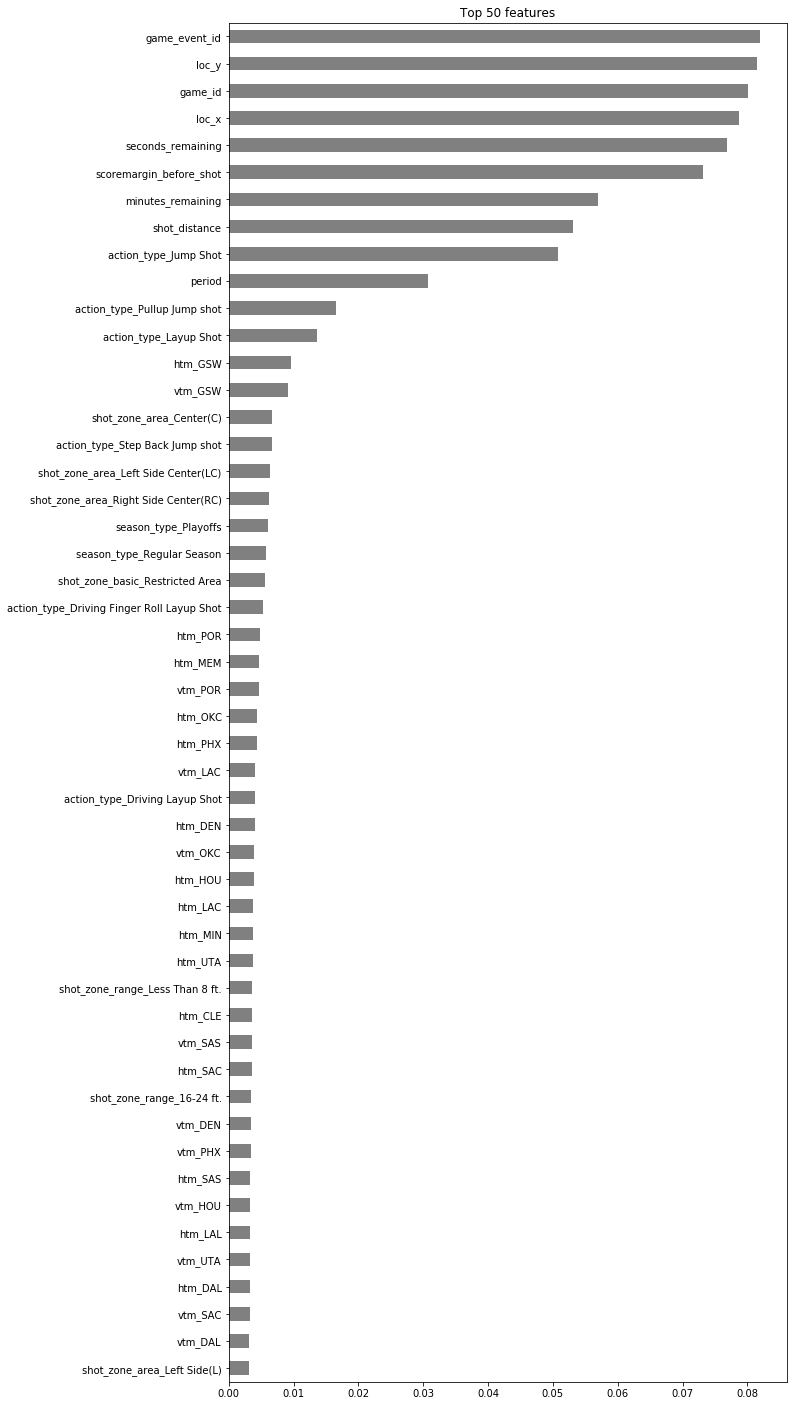

In [94]:
import matplotlib.pyplot as plt
# Get feature importances
encoder = pipeline.named_steps['onehotencoder']
rf = pipeline.named_steps['randomforestclassifier']
feature_names = encoder.transform(train.drop(labels=dropme, axis=1)).columns
importances = pd.Series(rf.feature_importances_, feature_names)

n = 50
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey')

### Calculate accuracy, precision, and recall for this confusion matrix:

In [110]:
corr_pos = 36
corr_neg = 85
false_pos = 58
false_neg = 8

true_pos = false_neg + corr_pos
true_neg = false_pos + corr_neg

pred_neg = false_neg + corr_neg
pred_pos = false_pos + corr_pos

precision_pos = corr_pos / pred_pos
precision_neg = corr_neg / pred_neg

recall_pos = corr_pos / true_pos
recall_neg = corr_neg / true_neg

accuracy = (corr_pos + corr_neg) / (true_pos + true_neg)

In [113]:
print(f"Positive Focus:\n precision: {precision_pos}\n recall: {recall_pos}\n accuracy: {accuracy}")

Positive Focus:
 precision: 0.3829787234042553
 recall: 0.8181818181818182
 accuracy: 0.6470588235294118


In [114]:
print(f"Negative Focus:\n precision: {precision_neg}\n recall: {recall_neg}\n accuracy: {accuracy}")

Negative Focus:
 precision: 0.9139784946236559
 recall: 0.5944055944055944
 accuracy: 0.6470588235294118
